In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("cat_dog_train\PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


In [53]:
#initial image size

image_size = (180, 180)
batch_size = 32

#training or validation are the key-word
#image_size: Size to resize images to after they are read from disk. Defaults to (256, 256). Since the pipeline processes batches of images that must all have the same size, this must be provided. 
#batch_size: Size of the batches of data. Default: 32. If None, the data will not be batched (the dataset will yield individual samples)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cat_dog_train\PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cat_dog_train\PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


In [54]:
#get the class name 
print("class name:",train_ds.class_names)

class name: ['Cat', 'Dog']


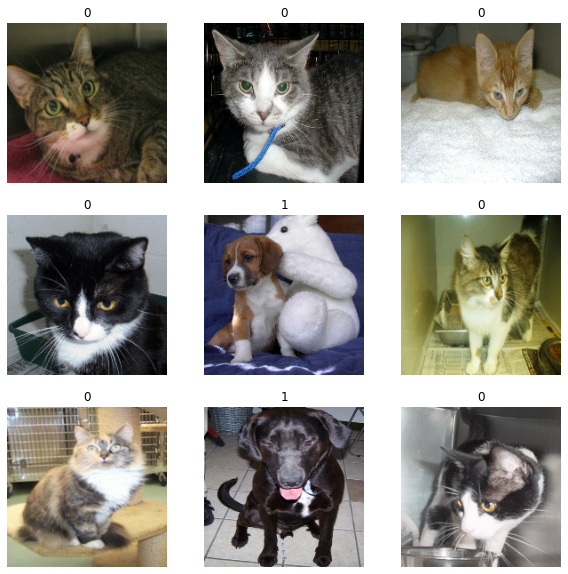

In [33]:
#print cat and dog image

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
#a batch_size of images (batch_size=32)
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
#data_augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
    ]
)

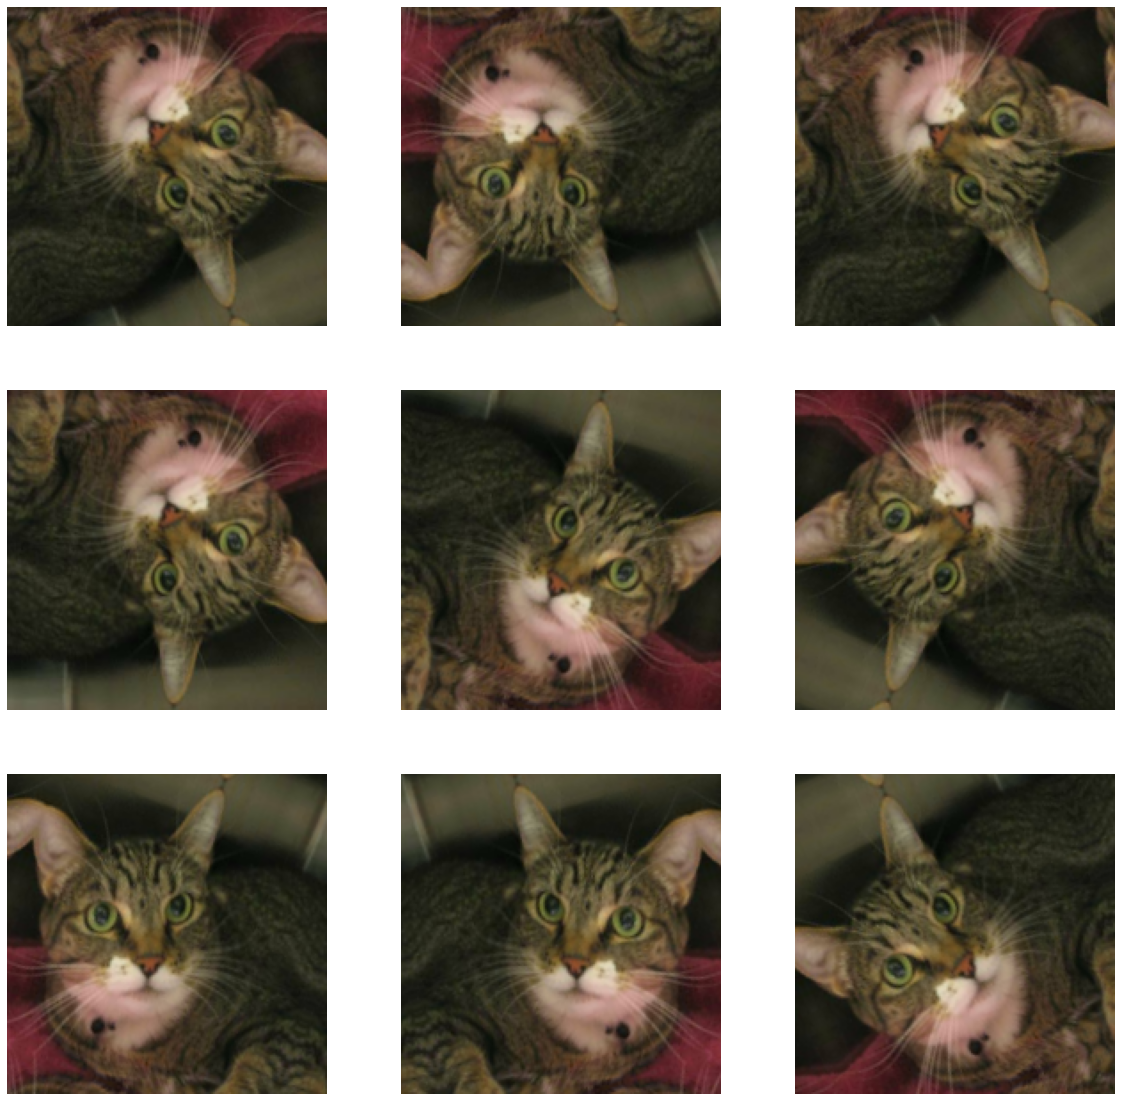

In [6]:
#data_augmentation

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


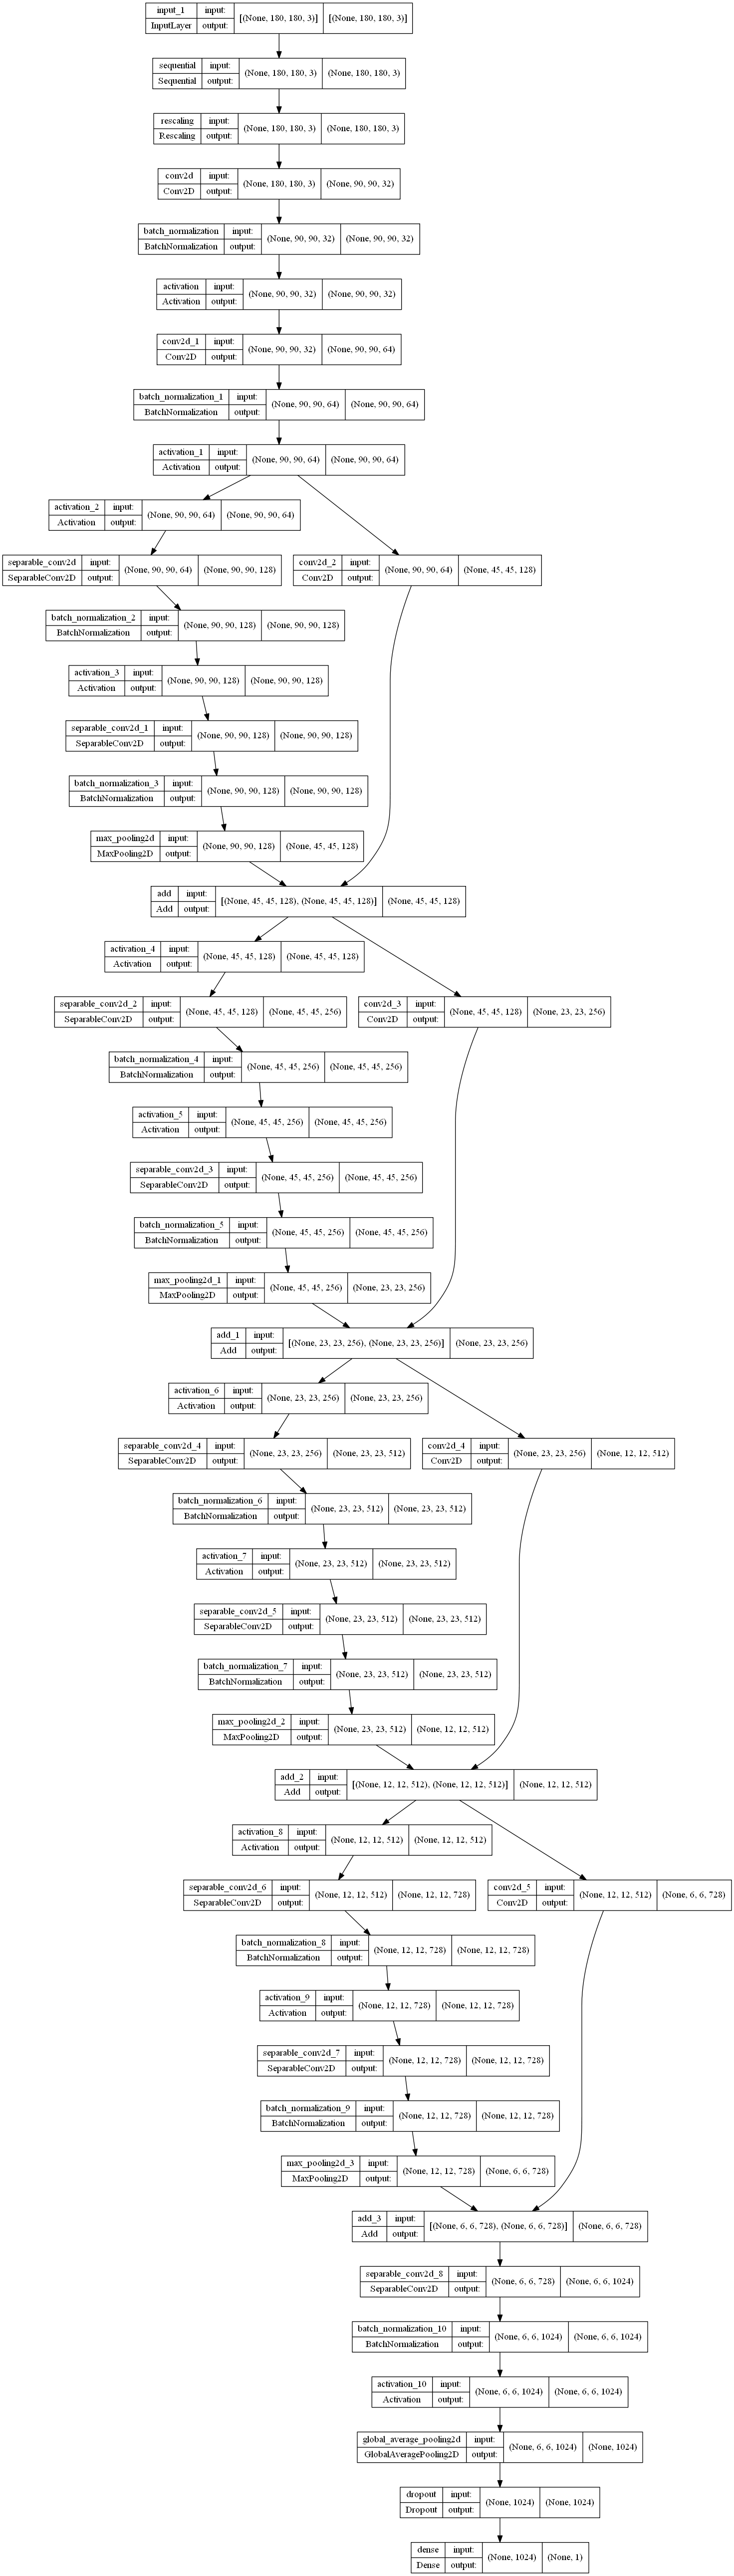

In [7]:
def make_model(input_shape, num_classes):
    #shape: (180,180,3)
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    #To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1/255
    x = layers.Rescaling(1.0 / 255)(x)
    #filters:32
    #kernal_size:3
    #padding: valid or same, valid means no padding, same means padding with zeros
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    #BatchNormalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
    x = layers.BatchNormalization()(x)
    #relu
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        #SeparableConv2D: separable convolutions can be understood as a way to factorize a convolution kernel into two smaller kernels, or as an extreme version of an Inception block
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        #pool_size:3 (3X3) pool window
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    #Global average pooling operation for spatial data
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        #for multi-classes classification last layer use softmax
        activation = "softmax"
        units = num_classes
    #Fraction of the input units to drop: 0.5
    x = layers.Dropout(0.5)(x)
    #Dense: regular densely-connected NN layer
    #units: Positive integer, dimensionality of the output space.
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

#if you see Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work
#check PPT page 49


In [8]:
epochs = 50

#partial model file 
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    #learning_rate:0.001
    optimizer=keras.optimizers.Adam(0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50
586/586 [==============================] - 752s 204ms/step - loss: 0.6458 - accuracy: 0.6507 - val_loss: 0.7190 - val_accuracy: 0.5564
Epoch 2/50
586/586 [==============================] - 118s 201ms/step - loss: 0.5332 - accuracy: 0.7373 - val_loss: 0.5110 - val_accuracy: 0.7498
Epoch 3/50
586/586 [==============================] - 118s 201ms/step - loss: 0.4703 - accuracy: 0.7782 - val_loss: 0.5649 - val_accuracy: 0.7526
Epoch 4/50
586/586 [==============================] - 118s 201ms/step - loss: 0.4258 - accuracy: 0.8080 - val_loss: 0.6729 - val_accuracy: 0.6904
Epoch 5/50
586/586 [==============================] - 118s 201ms/step - loss: 0.3845 - accuracy: 0.8317 - val_loss: 0.5346 - val_accuracy: 0.7506
Epoch 6/50
586/586 [==============================] - 118s 200ms/step - loss: 0.3571 - accuracy: 0.8416 - val_loss: 0.5986 - val_accuracy: 0.7287
Epoch 7/50
586/586 [==============================] - 118s 200ms/step - loss: 0.3370 - accuracy: 0.8538 - val_loss: 0.3444 -

In [21]:
#Run inference on new data

img = keras.preprocessing.image.load_img(
    #target_size: Either None (default to original size) or tuple of ints (img_height, img_width)
    "cat_dog_train/PetImages/Cat/6779.jpg", target_size=image_size
)
#img_to_array: Converts a PIL Image instance to a Numpy array
img_array = keras.preprocessing.image.img_to_array(img)
#expand_dims: Returns a tensor with a length 1 axis inserted at index
img_array = tf.expand_dims(img_array, 0) 


#model: groups layers into an object with training and inference features
#predict: Once the model is created, you can config the model with losses and metrics with model.compile(), train the model with model.fit(), or use the model to do prediction with model.predict()
predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


This image is 21.23 percent cat and 78.77 percent dog.


In [55]:
#it will create a folder and save model files into it
model.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


In [14]:
#load a self-trained model from a folder
new_model = tf.keras.models.load_model('my_model')

# Check its architecture
new_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

In [56]:
#save a model as a file
model.save('my_model.h5')

In [58]:
#load a self-trained model from a file
new_model1 = tf.keras.models.load_model('my_model.h5')

In [59]:
#check its architecture
new_model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

In [19]:
#use the self-trained model to prediction
img = keras.preprocessing.image.load_img(
    "cat_dog_train/PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = new_model1.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 99.25 percent cat and 0.75 percent dog.
